# Project Milestone P2

In [1]:
# Project Milestone P2 - Kushagra Shah
# Replicating Figure 1A

In [2]:
# Importing libraries
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt

In [3]:
# Assuming an extracted .txt file and loading the dataset
#profiles = pd.read_csv('data/EgoAlterProfiles.txt', sep = '\t', header = 0, index_col = 'ID')
#profiles.head()

In [4]:
# Extracting the ego profiles for the plot
#ego_profiles = profiles[profiles.IsEgo == True]
#ego_profiles.head()

#print("We have data for a total of %d user profiles" %(profiles.shape[0]))
#print("Out of which %d are ego profiles" %(ego_profiles.shape[0]))

In [5]:
# CCDF definition to be used for the plot
#def get_ccdf(vals):
    
    # Input:
    # -- vals: an np.array of positive integers
    # Output:
    # -- x: an array containing all numbers from 1 to max(vals);
    # -- y: an array containing the (empirically calculated) probability that vals <= x
    
#    y = np.cumsum(np.bincount(vals))
#    y = np.append(0,y)
#    y = 1 - y / y[-1]
#    x = list(set(vals))
#    y = [ y[i] for i in x ]
#    return x, y 

In [6]:
# Creating the plot depicting "Unequal content generation"
#plt.figure(figsize=(8,9))
#plt.title('Figure 1A: Log-log plot of the CCDF of the number of tweets per user',fontsize=14)

# Plotting for different Ns
#for i in range(6):
#    num_tweets = np.array(ego_profiles[ego_profiles.statuses_count>=i].statuses_count, dtype=int)
#    x, y = get_ccdf(num_tweets)
#    plt.loglog(x, y, 'o', ms=1)

#plt.xlabel('Number of Tweets x')
#plt.ylabel('Pr(x ≥ x)')
#plt.legend(title = 'N', labels = ['>=0','>=1','>=2','>=3','>=4','>=5'])
#plt.show()

In [7]:
########################################

# Project Milestone P4 B

In [8]:
# Project Milestone P4 B - Kushagra Shah
# Replicating Figure 2

In [9]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [10]:
# The SettingWithCopyWarning will trigger for false positives. Hence, turn it off
pd.set_option('mode.chained_assignment', None)

### Load and filter data

In [11]:
# Assume extracted .txt files and load the datasets
profiles = pd.read_csv('data/EgoAlterProfiles.txt', sep = '\t', header = 0, encoding = 'latin-1')
timelines = pd.read_csv('data/EgoTimelines.txt', sep = '\t', header = 0, encoding = 'latin-1')

In [12]:
# Filter the profiles df according to the S1 File:

# 1) Find the egos 
ego_profiles = profiles[profiles.IsEgo == True]

# 2) Find the active users (use timelines df to find egos with at least 1 tweet)
active_users = timelines['egoID'].unique()
active_profiles = ego_profiles[ego_profiles['ID'].isin(active_users)]

# 3) Find the users with a valid (not a NaN) UTC offset
activeUTC_profiles = active_profiles[active_profiles['utc_offset'].notnull()]

In [13]:
# Check if the dataframe matches with the one mentioned in the S1 File:
print("We have information about %d users, out of which %d users are egos. Further..." 
      %(profiles.shape[0], ego_profiles.shape[0]))
print("There are %d active egos, out of which %d users have the UTC offset information." 
      %(active_profiles.shape[0], activeUTC_profiles.shape[0]))

# Yes, it does!

We have information about 2516190 users, out of which 34006 users are egos. Further...
There are 17244 active egos, out of which 4222 users have the UTC offset information.


In [14]:
# Filter the timelines df to only keep the tweets from egos with UTC offset information
activeUTC_list = activeUTC_profiles['ID'].tolist()
utc_timelines = timelines[timelines['egoID'].isin(activeUTC_list)]

In [15]:
# Filtered profiles df - Reference
activeUTC_profiles.head()

,ID,IsEgo,followers_count,friends_count,statuses_count,utc_offset,lang,created_at,protected
1,2,True,2.0,8,7.0,-14400.0,en,Mon Jul 27 20:46:32 +0000 2009,False
8,9,True,26.0,16,6.0,-10800.0,en,Sun Feb 14 10:49:28 +0000 2010,False
20,21,True,14.0,21,473.0,-14400.0,en,Thu Apr 30 16:29:40 +0000 2009,False
21,22,True,218.0,196,5826.0,3600.0,es,Sun Jun 06 23:12:12 +0000 2010,False
25,26,True,139.0,150,4164.0,-36000.0,en,Wed Jan 06 16:39:59 +0000 2010,False


In [16]:
# Filtered timelines df - Reference
utc_timelines.head()

,replyto_userid,retweeted_userid,id,tweetid,created_at,hashtags,urls,mentions_ids,retweet_count,egoID,retweetedUserID,replytoUserID,metionID
9,NaN,NaN,60705288,266183173514354689,Wed Nov 07 14:19:48 +0000 2012,NaN,http://t.co/f4iUVq3i,NaN,0,2,NaN,NaN,NaN
10,NaN,NaN,60705288,171568792365830144,Mon Feb 20 12:16:02 +0000 2012,NaN,NaN,NaN,0,2,NaN,NaN,NaN
11,NaN,NaN,60705288,265700869520101376,Tue Nov 06 06:23:18 +0000 2012,NaN,http://t.co/HPBDRag6,NaN,0,2,NaN,NaN,NaN
12,NaN,NaN,60705288,2877149834,Mon Jul 27 20:48:55 +0000 2009,NaN,NaN,NaN,0,2,NaN,NaN,NaN
13,NaN,NaN,60705288,171567834793656320,Mon Feb 20 12:12:14 +0000 2012,NaN,http://t.co/2ElP3Ghw,NaN,0,2,NaN,NaN,NaN


### Use the UTC offset to calculate local time

In [17]:
# Convert the given 'created at' string format to a standard datetime object:

# Simple function to convert time format
def convert_time_format(twt_time: str):
    std_time = datetime.strptime(twt_time, '%a %b %d %H:%M:%S %z %Y')
    return std_time

# Add the standard datetime format to a new column
utc_timelines['std_time'] = utc_timelines['created_at'].astype('str').apply(convert_time_format)

In [18]:
# Transfer the UTC offset information from the profile df to the corresponding tweet in the timelines df:

# Create a dictionary mapping between the egoIDs and their corresponding UTC offsets
utc_offsets = dict(zip(activeUTC_profiles['ID'], activeUTC_profiles['utc_offset']))

# Simple function to extract UTC offset using the ego ID
def get_utc_offset(ID):
    return utc_offsets[ID]

# Add a new column for the UTC offset corresponding to the ego ID for each tweet
utc_timelines['utc_offset'] = utc_timelines['egoID'].apply(get_utc_offset)

In [19]:
# Convert the UTC offset information to a more usable timedelta format:

# Simple function to convert the 'seconds' from a float to timedelta object
def float_to_timedelta(f):
    return timedelta(seconds = f)

# Replace the UTC offset information by converting the format
utc_timelines['utc_offset'] = utc_timelines['utc_offset'].apply(float_to_timedelta)

In [20]:
# New columns in the timelines df - Reference
utc_timelines.head()

,replyto_userid,retweeted_userid,id,tweetid,created_at,hashtags,urls,mentions_ids,retweet_count,egoID,retweetedUserID,replytoUserID,metionID,std_time,utc_offset
9,NaN,NaN,60705288,266183173514354689,Wed Nov 07 14:19:48 +0000 2012,NaN,http://t.co/f4iUVq3i,NaN,0,2,NaN,NaN,NaN,2012-11-07 14:19:48+00:00,-1 days +20:00:00
10,NaN,NaN,60705288,171568792365830144,Mon Feb 20 12:16:02 +0000 2012,NaN,NaN,NaN,0,2,NaN,NaN,NaN,2012-02-20 12:16:02+00:00,-1 days +20:00:00
11,NaN,NaN,60705288,265700869520101376,Tue Nov 06 06:23:18 +0000 2012,NaN,http://t.co/HPBDRag6,NaN,0,2,NaN,NaN,NaN,2012-11-06 06:23:18+00:00,-1 days +20:00:00
12,NaN,NaN,60705288,2877149834,Mon Jul 27 20:48:55 +0000 2009,NaN,NaN,NaN,0,2,NaN,NaN,NaN,2009-07-27 20:48:55+00:00,-1 days +20:00:00
13,NaN,NaN,60705288,171567834793656320,Mon Feb 20 12:12:14 +0000 2012,NaN,http://t.co/2ElP3Ghw,NaN,0,2,NaN,NaN,NaN,2012-02-20 12:12:14+00:00,-1 days +20:00:00


In [21]:
# Adjust the tweet time to local time by adding the UTC offset
utc_timelines['local_time'] = utc_timelines['std_time'] + utc_timelines['utc_offset']

In [22]:
# Extract the information about the day and hour of the tweet (to be used for the plot)

# Simple function to extract day
def get_day(time_obj):
    return time_obj.strftime('%a')
# Simple function to extract hour
def get_hour(time_obj):
    return int(time_obj.strftime('%H'))

# Add new columns for the day and hour information for each tweet
utc_timelines['Day'] = utc_timelines['local_time'].apply(get_day)
utc_timelines['Hour'] = utc_timelines['local_time'].apply(get_hour)

In [23]:
# New columns in the timelines df - Reference
utc_timelines.head()

,replyto_userid,retweeted_userid,id,tweetid,created_at,hashtags,urls,mentions_ids,retweet_count,egoID,retweetedUserID,replytoUserID,metionID,std_time,utc_offset,local_time,Day,Hour
9,NaN,NaN,60705288,266183173514354689,Wed Nov 07 14:19:48 +0000 2012,NaN,http://t.co/f4iUVq3i,NaN,0,2,NaN,NaN,NaN,2012-11-07 14:19:48+00:00,-1 days +20:00:00,2012-11-07 10:19:48+00:00,Wed,10
10,NaN,NaN,60705288,171568792365830144,Mon Feb 20 12:16:02 +0000 2012,NaN,NaN,NaN,0,2,NaN,NaN,NaN,2012-02-20 12:16:02+00:00,-1 days +20:00:00,2012-02-20 08:16:02+00:00,Mon,8
11,NaN,NaN,60705288,265700869520101376,Tue Nov 06 06:23:18 +0000 2012,NaN,http://t.co/HPBDRag6,NaN,0,2,NaN,NaN,NaN,2012-11-06 06:23:18+00:00,-1 days +20:00:00,2012-11-06 02:23:18+00:00,Tue,2
12,NaN,NaN,60705288,2877149834,Mon Jul 27 20:48:55 +0000 2009,NaN,NaN,NaN,0,2,NaN,NaN,NaN,2009-07-27 20:48:55+00:00,-1 days +20:00:00,2009-07-27 16:48:55+00:00,Mon,16
13,NaN,NaN,60705288,171567834793656320,Mon Feb 20 12:12:14 +0000 2012,NaN,http://t.co/2ElP3Ghw,NaN,0,2,NaN,NaN,NaN,2012-02-20 12:12:14+00:00,-1 days +20:00:00,2012-02-20 08:12:14+00:00,Mon,8


### The visualization

In [24]:
# Create a new dataframe for the tweets plot
tweets_plot = utc_timelines.groupby(['Day', 'Hour']).size().reset_index(name = 'num_of_tweets')

# Reference
#tweets_plot.head()

In [25]:
# Create a new dataframe for the active users plot
active_users_plot = utc_timelines.groupby(['Day', 'Hour'])['egoID'].nunique().reset_index(name = 'num_of_active_users')

# Reference
#active_users_plot.head()

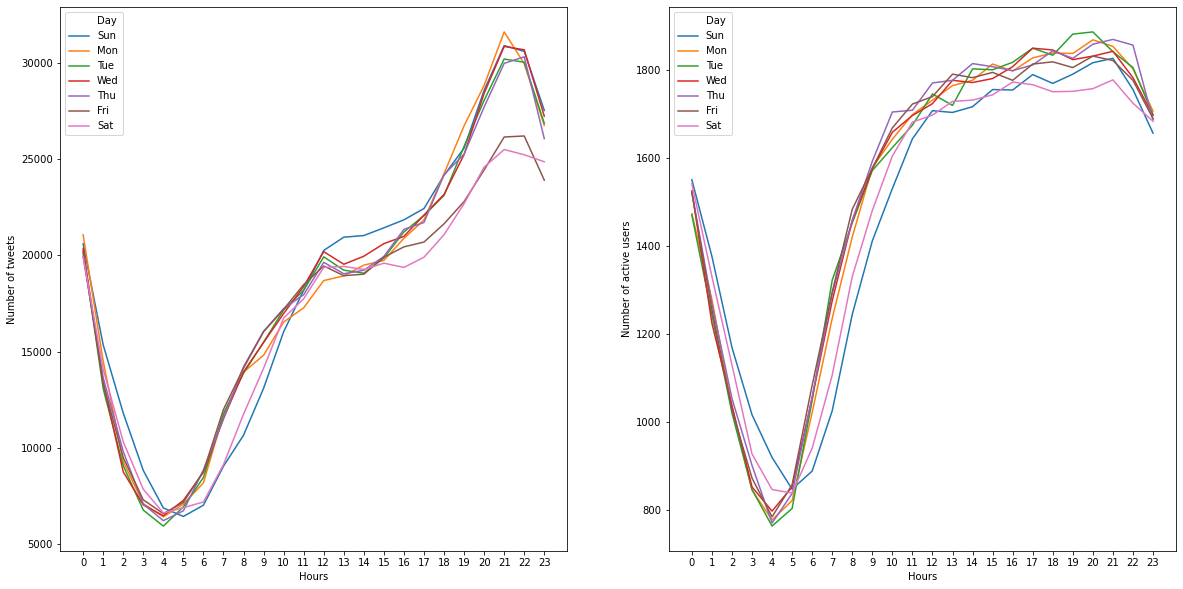

In [26]:
# Finally, the complete plot using seaborn:

# Set up the dimensions for the plot
fig, ax = plt.subplots(1, 2, figsize = (20, 10))

# Sub-plot the number of tweets
sns.lineplot(data = tweets_plot, x = 'Hour', y = 'num_of_tweets', hue = 'Day', ax = ax[0],
            hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[0].set_xlabel('Hours')
ax[0].set_ylabel('Number of tweets')
ax[0].set_xticks(np.arange(0, 24))

# Sub-plot the number of active users
sns.lineplot(data = active_users_plot, x = 'Hour', y = 'num_of_active_users', hue = 'Day', ax = ax[1],
            hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[1].set_xlabel('Hours')
ax[1].set_ylabel('Number of active users')
ax[1].set_xticks(np.arange(0, 24))

plt.show()

### Conclusion:
The figure 2 from the reference paper has been replicated **exactly**. One can clearly see the circadian rhythm pattern in Twitter activity. The number of tweets and the number of active users increase from the morning to night, and then fall back down. This pattern repeats daily with a slightly less number of tweets and active users during the end of the week. 